In [1]:
#from google.colab import files

In [1]:
import itertools
import pandas as pd
import numpy as np
import random
import csv
import time

import matplotlib.pyplot as plt

import tensorflow as tf

import keras.backend as K
from keras import Sequential
from keras.layers import Dense, Dropout

# Book data Generator

In [3]:
# !wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
# !unzip -q ml-100k.zip

In [4]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Books.csv

--2020-11-24 23:06:01--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Books.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
접속 deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 2140933459 (2.0G) [application/octet-stream]
Saving to: ‘Books.csv.1’

Books.csv.1           0%[                    ]   2.43M   770KB/s    eta 45m 11s^C


## 1. 데이터 전처리

### Integer로 Encoding

In [2]:
pure_datapath = './data/Books.csv'
pure_data = pd.read_csv(pure_datapath, names=['item', 'user', 'rating', 'timestamp'])

In [3]:
pure_data.head()

,item,user,rating,timestamp
0,0001713353,A1C6M8LCIX4M6M,5.0,1123804800
1,0001713353,A1REUF3A1YCPHM,5.0,1112140800
2,0001713353,A1YRBRK2XM5D5,5.0,1081036800
3,0001713353,A1V8ZR5P78P4ZU,5.0,1077321600
4,0001713353,A2ZB06582NXCIV,5.0,1475452800


In [4]:
# User: str to int
pure_data.user = pd.Categorical(pure_data.user)
pure_data['user'] = pure_data.user.cat.codes

# Item: str to int
pure_data.item = pd.Categorical(pure_data.item)
pure_data['item'] = pure_data.item.cat.codes

pure_data.head()

,item,user,rating,timestamp
0,122,1376859,5.0,1123804800
1,122,3094405,5.0,1112140800
2,122,3923726,5.0,1081036800
3,122,3527298,5.0,1077321600
4,122,8042828,5.0,1475452800


In [5]:
pure_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51311621 entries, 0 to 51311620
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   item       int32  
 1   user       int32  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int32(2), int64(1)
memory usage: 1.1 GB


In [6]:
pure_data['rating'] = pure_data['rating'].astype('int8')

In [7]:
pure_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51311621 entries, 0 to 51311620
Data columns (total 4 columns):
 #   Column     Dtype
---  ------     -----
 0   item       int32
 1   user       int32
 2   rating     int8 
 3   timestamp  int64
dtypes: int32(2), int64(1), int8(1)
memory usage: 831.9 MB


In [10]:
pure_data.to_csv('./data/books_idx.csv', index=False)

### 데이터 분석

In [8]:
print("Unique users in the total data: ", pure_data.user.nunique())
print("Unique item in the total data: ", pure_data.item.nunique())
print("Unique rating in the total data: ", pure_data.rating.nunique())
print("Unique timestamp in the total data: ", pure_data.timestamp.nunique())
pure_data.isnull().sum()

Unique users in the total data:  15362619
Unique item in the total data:  2930451
Unique rating in the total data:  6
Unique timestamp in the total data:  7837


item         0
user         0
rating       0
timestamp    0
dtype: int64

### Rating의 분포

In [53]:
rating_value_counts = pure_data['rating'].value_counts()

In [54]:
rating_value_counts_ratings = rating_value_counts.keys().to_numpy()
rating_value_counts_counts = rating_value_counts.to_numpy()

5    33979736
4     9557650
3     3835225
1     2088314
2     1850688
0           8
Name: rating, dtype: int64


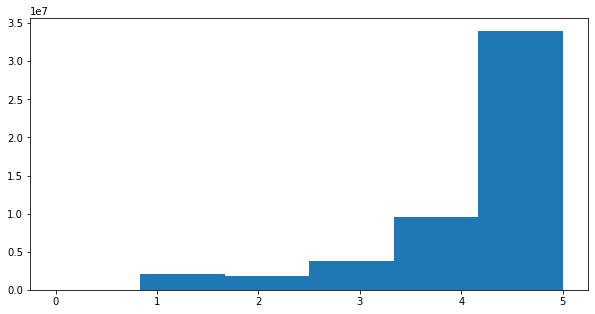

In [55]:
plt.figure(figsize=(10, 5), facecolor='w')
plt.hist(pure_data['rating'], bins=6)
print(pure_data.rating.value_counts())

In [57]:
print('rating 4, 5의 비율: ', sum(rating_value_counts_counts[:2]) / sum(rating_value_counts_counts) * 100)

rating 4, 5의 비율:  84.84897797323534


In [59]:
print('rating 5의 비율: ', sum(rating_value_counts_counts[:1]) / sum(rating_value_counts_counts) * 100)

rating 5의 비율:  66.22230079225133


### rating 개수에 따른 user의 분포

In [11]:
user_value_counts = pure_data['user'].value_counts()
print(user_value_counts)

6831279     9684
5775864     9074
8373854     7077
13318960    5842
3752841     4437
            ... 
2965879        1
7162230        1
11358581       1
7194982        1
8074499        1
Name: user, Length: 15362619, dtype: int64


In [15]:
user_value_counts_users = user_value_counts.keys().to_numpy()
user_value_counts_counts = user_value_counts.to_numpy()

In [16]:
print(user_value_counts_users)
print(user_value_counts_counts)

[ 6831279  5775864  8373854 ... 11358581  7194982  8074499]
[9684 9074 7077 ...    1    1    1]


In [17]:
user_value_counts_users.shape

(15362619,)

In [18]:
user_value_counts_users[(user_value_counts_counts>20)].shape

(279964,)

In [27]:
temp = user_value_counts_counts[(user_value_counts_counts<1000) & (user_value_counts_counts>=20)]

(array([2.1603e+04, 1.9155e+04, 1.7396e+04, 1.5242e+04, 1.3951e+04,
        1.2580e+04, 1.1607e+04, 1.0344e+04, 9.5010e+03, 8.7630e+03,
        8.0220e+03, 7.2510e+03, 6.8100e+03, 6.2710e+03, 5.8130e+03,
        5.4400e+03, 5.0620e+03, 4.7170e+03, 4.5620e+03, 4.1860e+03,
        3.8960e+03, 3.6910e+03, 3.4130e+03, 3.1170e+03, 3.0100e+03,
        2.9440e+03, 2.7530e+03, 2.6180e+03, 2.3400e+03, 2.2870e+03,
        2.1880e+03, 2.0490e+03, 1.9770e+03, 1.8730e+03, 1.8490e+03,
        1.6950e+03, 1.6810e+03, 1.5290e+03, 1.4850e+03, 1.4770e+03,
        1.3380e+03, 1.3170e+03, 1.2620e+03, 1.2350e+03, 1.1260e+03,
        0.0000e+00, 1.1680e+03, 1.1200e+03, 1.0480e+03, 1.0140e+03,
        9.7600e+02, 9.1700e+02, 8.9100e+02, 8.3000e+02, 7.9900e+02,
        7.9700e+02, 6.9900e+02, 7.6200e+02, 7.1300e+02, 7.0200e+02,
        7.0400e+02, 6.9000e+02, 6.4600e+02, 6.1100e+02, 6.2000e+02,
        5.9300e+02, 5.3600e+02, 5.5300e+02, 5.9000e+02, 5.0900e+02,
        5.2500e+02, 5.0200e+02, 4.6000e+02, 4.61

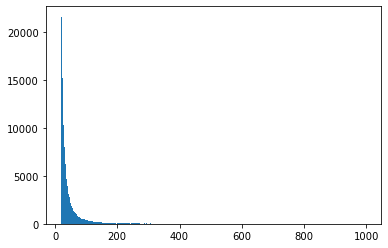

In [28]:
plt.figure(facecolor='w')
plt.hist(temp, bins=1000)

In [29]:
temp = user_value_counts_counts[(user_value_counts_counts<100) & (user_value_counts_counts>=20)]

(array([21603., 19155., 17396., 15242.,     0., 13951., 12580., 11607.,
        10344.,     0.,  9501.,  8763.,  8022.,  7251.,     0.,  6810.,
         6271.,  5813.,  5440.,     0.,  5062.,  4717.,  4562.,     0.,
         4186.,  3896.,  3691.,  3413.,     0.,  3117.,  3010.,  2944.,
         2753.,     0.,  2618.,  2340.,  2287.,  2188.,     0.,  2049.,
         1977.,  1873.,     0.,  1849.,  1695.,  1681.,  1529.,     0.,
         1485.,  1477.,  1338.,  1317.,     0.,  1262.,  1235.,  1126.,
         1168.,     0.,  1120.,  1048.,  1014.,     0.,   976.,   917.,
          891.,   830.,     0.,   799.,   797.,   699.,   762.,     0.,
          713.,   702.,   704.,   690.,     0.,   646.,   611.,   620.,
            0.,   593.,   536.,   553.,   590.,     0.,   509.,   525.,
          502.,   460.,     0.,   461.,   450.,   373.,   477.,     0.,
          420.,   411.,   366.,   400.]),
 array([20.  , 20.79, 21.58, 22.37, 23.16, 23.95, 24.74, 25.53, 26.32,
        27.11, 27.9 , 2

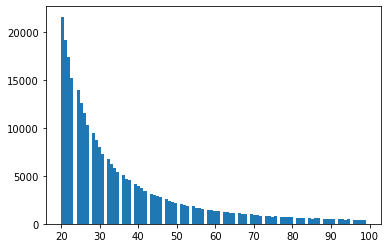

In [30]:
plt.figure(facecolor='w')
plt.hist(temp, bins=100)

### rating 개수에 따른 item의 분포

In [32]:
item_value_counts = pure_data['item'].value_counts()
print(item_value_counts)

288015     58150
168974     44956
5794       44381
100968     37783
205270     36620
           ...  
2890148        1
1073306        1
2701241        1
1138874        1
2527543        1
Name: item, Length: 2930451, dtype: int64


In [33]:
item_value_counts_items = item_value_counts.keys().to_numpy()
item_value_counts_counts = item_value_counts.to_numpy()

In [34]:
print("Average counts of items per user: ", len(item_value_counts_counts) / len(user_value_counts_counts))

Average counts of items per user:  0.1907520455984751


In [36]:
item_value_counts_items.shape

(2930451,)

(array([1.4861e+04, 1.3869e+04, 1.2957e+04, 1.1854e+04, 1.1185e+04,
        1.0293e+04, 9.8440e+03, 9.1190e+03, 8.6860e+03, 8.3330e+03,
        8.0360e+03, 7.4820e+03, 7.0970e+03, 6.5740e+03, 6.1350e+03,
        6.0010e+03, 5.7070e+03, 5.4450e+03, 5.1860e+03, 4.9210e+03,
        4.7430e+03, 4.5450e+03, 4.2800e+03, 4.2680e+03, 4.0250e+03,
        3.7320e+03, 3.6980e+03, 3.6430e+03, 3.4850e+03, 3.2180e+03,
        3.0880e+03, 3.1580e+03, 3.1010e+03, 2.8520e+03, 2.8900e+03,
        2.7500e+03, 2.6610e+03, 2.4910e+03, 2.5390e+03, 2.3060e+03,
        2.3020e+03, 2.2370e+03, 2.0900e+03, 2.1200e+03, 1.9850e+03,
        0.0000e+00, 2.0090e+03, 1.9670e+03, 1.8800e+03, 1.8020e+03,
        1.8070e+03, 1.7590e+03, 1.6730e+03, 1.6230e+03, 1.5450e+03,
        1.5620e+03, 1.5480e+03, 1.5470e+03, 1.4570e+03, 1.4390e+03,
        1.3930e+03, 1.3580e+03, 1.3190e+03, 1.2820e+03, 1.3010e+03,
        1.2320e+03, 1.2370e+03, 1.1780e+03, 1.1670e+03, 1.1020e+03,
        1.1270e+03, 1.0510e+03, 1.0640e+03, 9.90

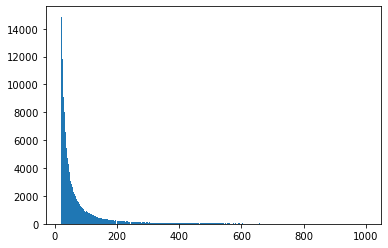

In [45]:
temp = item_value_counts_counts[(item_value_counts_counts<1000) & (item_value_counts_counts>20)]
plt.figure(facecolor='w')
plt.hist(temp, bins=1000)

### timestamp 분석

In [60]:
pure_data = pure_data.sort_values('timestamp')
pure_data.head()

,item,user,rating,timestamp
3482167,93865,10599777,4,832550400
3476836,93540,6912524,5,833500800
18394619,970012,9578352,5,835315200
11181984,346071,11257537,1,835660800
12923138,445737,11257537,5,840240000


In [61]:
timestamp_value_counts = pure_data['timestamp'].value_counts(sort=False)
timestamp_value_counts.head()

1415318400    22680
1229990400     1858
1044662400      715
1474329600    24310
1289001600     2333
Name: timestamp, dtype: int64

In [62]:
timestamp_value_counts = timestamp_value_counts.sort_index()
timestamp_value_counts.head()

832550400    1
833500800    1
835315200    1
835660800    1
840240000    1
Name: timestamp, dtype: int64

In [64]:
timestamp_value_counts_timestamps = timestamp_value_counts.keys().to_numpy()
timestamp_value_counts_counts = timestamp_value_counts.to_numpy()

In [65]:
print('Total number of data: ', pure_data['timestamp'].shape[0])
print('Unique timestamp: ', timestamp_value_counts_timestamps.shape[0])

Total number of data:  51311621
Unique timestamp:  7837


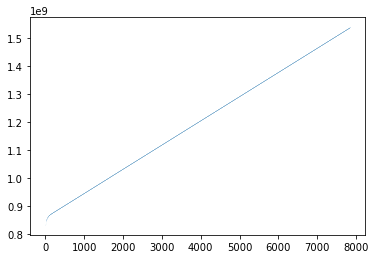

In [66]:
plt.figure(facecolor='w')
plt.plot(timestamp_value_counts_timestamps, 'o', ms=0.01)

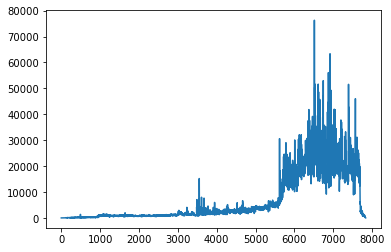

In [67]:
plt.figure(facecolor='w')
plt.plot(timestamp_value_counts_counts)

### Data Summary
-  평점의 분포가 4, 5점, 특히 5점이 압도적으로 많다    => 추천 알고리즘이라서 크게 문제되지 않을 수 있음     
     
-  user 별 rating 개수의 upperbound 와 lowerbound를 어떻게 정하느냐에 따라 데이터 분포가 크게 달라짐  
  
-  timestamp는 연속적인 값을 가지지만, histogram의 분포는 최근에 매우 몰려 있다.  => 큰 문제로 보이진 않음  

-  동시에 여러개의 item을 구매한 user의 처리  

-  동일한 item을 여러개 구매한 user의 처리


### Test 해봐야할 것
- data를 user의 count에 따라 어떻게 나눌지 정해야 한다.
- movielens 데이터에서 N>20 의 기준으로 자른 것이 강화학습의 MDP 관점에서 bias가 얼마나 있을지 생각해야한다
  => lowerbound와 upperbound 설정에 따른 성능 비교 필요

#### test 1. upper: 120, lower: 20

In [ ]:
processed_data = pure_data.set_index('user')

In [76]:
Upper_N = 120
Lower_N = 20

In [77]:
user_indices = user_value_counts_users[(user_value_counts_counts<Upper_N) & (user_value_counts_counts>Lower_N)]

print("Counts of data BEFORE slicing: ", len(processed_data))

proccesed_data = processed_data.loc[user_indices]
print("Counts of data AFTER slicing: ", len(processed_data))

NameError: name 'processed_data' is not defined

In [ ]:
user_value_counts_users[(user_value_counts_counts<Upper_N) & (user_value_counts_counts>Lower_N)][:10], user_value_counts_counts[(user_value_counts_counts<Upper_N) & (user_value_counts_counts>Lower_N)][:10]

## 2. DataGenerator

In [14]:
class DataGenerator():
    def __init__(self, datapath):
        self.data = self.load_datas(datapath)
        self.users = self.data['user'].unique()
        self.items = self.data['item'].unique()
        self.histo = self.gen_histo()
        self.train = []
        self.test = []
        #self.data_small
        
    
    def load_datas(self, datapath):
        #data = pd.read_csv(datapath, names=['item', 'user', 'rating', 'timestamp'])
        data = pd.read_csv(datapath, dtype={'item': int, 'user': int, 'rating': int, 'timestamp': int}, header=0)
        #data2 = data.astype({'item': str, 'user': str, 'rating': int, 'timestamp': int})
        #data['item'] = data['item'].astype(str)
        #data['user'] = data['user'].astype(str)
        #data['rating'] = data['rating'].astype(str)
        #data['rating'] = data['rating'].astype(int)
        #data['timestamp'] = data['timestamp'].astype(str)
        #data['timestamp'] = data['timestamp'].astype(int)

        #print(type(data2['item']), type(data2['user']), type(data2['rating']), type(data2['timestamp']))

        #data2.head()

        return data
    
    def gen_histo(self):
        historic_users = []
        for i, u in enumerate(self.users):
            #self.data_small = self.data[self.data['user'] == u]
            temp = self.data[self.data['user'] == u]
            temp = temp.sort_values('timestamp').reset_index()
            temp.drop('index', axis=1, inplace=True)
            historic_users.append(temp)
        return historic_users
    
    def sample_histo(self, user_histo, action_ratio=0.8, 
                     max_samp_by_user=5, max_state=100, max_action=50, nb_states=[], nb_actions=[]):
        n = len(user_histo)
        
        sep = int(action_ratio * n)
        nb_sample = random.randint(1, max_samp_by_user)

        if not nb_states:
            nb_states = [min(random.randint(1, sep), max_state) for i in range(nb_sample)]
        if not nb_actions:
            nb_actions = [min(random.randint(1, n-sep), max_action) for i in range(nb_sample)]
        
        assert len(nb_states) == len(nb_actions)

        states = []
        actions = []

        

        for i in range(len(nb_states)):
            
            sample_states = user_histo.iloc[0:sep].sample(nb_states[i])
            sample_actions = user_histo.iloc[-(n-sep):].sample(nb_actions[i])

                
            sample_state = []
            sample_action = []
            for j in range(nb_states[i]):
                row = sample_states.iloc[j]
                # FORMAT STATE
                state = str(row.loc['item']) + '&' + str(row.loc['rating'])
                sample_state.append(state)
            
            for j in range(nb_actions[i]):
                row = sample_actions.iloc[j]
                # FORMAT ACTION
                action = str(row.loc['item']) + '&' + str(row.loc['rating'])
                sample_action.append(action)
            
            states.append(sample_state)
            actions.append(sample_action)
            
        return states, actions

    def gen_train_test(self, test_ratio, seed=None):
        print('gen_train start')
        n = len(self.histo)

        if seed is not None:
            random.Random(seed).shuffle(self.histo)
        else:
            random.shuffle(self.histo)

        self.train = self.histo[:int((test_ratio * n))]
        self.test = self.histo[int((test_ratio * n)):]
        self.user_train = [h.iloc[1,1] for h in self.train]
        print(self.user_train[0])
        self.user_test = [h.iloc[1,1] for h in self.test]

    def write_csv(self, filename, histo_to_write, delimiter=';', action_ratio=0.8, 
                  max_samp_by_user=5, max_state=100, max_action=50, nb_states=[], nb_actions=[]):
         with open(filename, mode='w') as file:
            f_writer = csv.writer(file, delimiter=delimiter)
            f_writer.writerow(['state', 'action_reward', 'n_state'])
            for user_histo in histo_to_write:
                states, actions = self.sample_histo(user_histo, action_ratio, 
                                                    max_samp_by_user, max_state, max_action, nb_states, nb_actions)
                for i in range(len(states)):
                    # FORMAT STATE
                    state_str = '|'.join(states[i])
                    # FORMAT ACTION
                    action_str = '|'.join(actions[i])
                    # FORMAT N_STATE
                    n_state_str = state_str + '|' + action_str
                    f_writer.writerow([state_str, action_str, n_state_str])



In [16]:
# Hyperparameters
history_length = 12 # N in article
ra_length = 4 # K in article
discount_factor = 0.99 # Gamma in Bellman equation
actor_lr = 0.0001
critic_lr = 0.001
tau = 0.001 # τ in Algorithm 3
batch_size = 64
nb_episodes = 100
nb_rounds = 50
filename_summary = 'summary.txt'
alpha = 0.5 # α (alpha) in Equation (1)
gamma = 0.9 # Γ (Gamma) in Equation (4)
buffer_size = 1000000 # Size of replay memory D in article
fixed_length = True # Fixed memory length

'''
datapath = '/content/books_3000.csv'
dg = DataGenerator(datapath)
dg.gen_train_test(0.8, seed=42)

print(len(dg.train))
print(len(dg.test))
print('train: ', dg.train[:10])
print('test:', dg.test[:10])

dg.write_csv('books_train.csv', dg.train, nb_states=[history_length], nb_actions=[ra_length])
dg.write_csv('books_test.csv', dg.test, nb_states=[history_length], nb_actions=[ra_length])

data = read_file('books_train.csv')
'''

FileNotFoundError: [Errno 2] File /content/books_3000.csv does not exist: '/content/books_3000.csv'

## 3. Embedding Generator

In [ ]:
import tqdm

In [ ]:
class EmbeddingsGenerator:
    def __init__(self, train_users, data):
        print('train_users: ', train_users)
        print('data: ', data)
        self.train_users = train_users

        #preprocess
        self.data = data.sort_values(by=['timestamp'])
        #make them start at 0
        # self.data['user'] = self.data['user'] 
        # self.data['item'] = self.data['item']
        self.user_count = self.data['user'].max() + 1
        self.book_count = self.data['item'].max() + 1
        self.user_books = {} #list of rated movies by each user
        for userId in range(self.user_count):
            self.user_books[userId] = self.data[self.data.user == userId]['item'].tolist()
        self.m = self.model()
    
    def model(self, hidden_layer_size=100):
        m = Sequential()
        m.add(Dense(hidden_layer_size, input_shape=(1, self.book_count)))
        m.add(Dropout(0.2))
        m.add(Dense(self.book_count, activation='softmax'))
        m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return m
    
    def generate_input(self, user):
        '''
        Returns a context and a target for the user
        
        context: user's history with one random book removed
        target: id of random removed book
        '''
        print('generate input')
        print(user)
        print(self.user_books)
        user_books_count = len(self.user_books[user])
        # picking random book
        random_index = np.random.randint(0, user_books_count-1) # -1 avoids taking the las book
        # setting target
        target = np.zeros((1, self.book_count))
        target[0][self.user_books[user][random_index]] = 1
        # setting context
        context = np.zeros((1, self.book_count))
        context[0][self.user_books[user][:random_index] + self.user_books[user][random_index + 1:]] = 1
        return context, target
    
    def train(self, nb_epochs=300, batch_size=10000):
        '''
        Trains the model from train_users's history
        '''
        print('train start')
        for i in range(nb_epochs):
            print('%d/%d' % (i+1, nb_epochs))
            #batch = [self.generate_input(user=np.random.choice(self.train_users) - 1) for _ in range(batch_size)]
            batch = [self.generate_input(user=np.random.choice(self.train_users)) for _ in range(batch_size)]
            X_train = np.array([b[0] for b in batch])
            y_train = np.array([b[0] for b in batch])
            self.m.fit(X_train, y_train, epochs=1, validation_split=0.5)
        
    def test(self, test_users, batch_size=10000):
        '''
        Returns [loss, accuracy] on the test set
        '''
        batch_test = [self.generate_input(user=np.random.choice(test_users)) for _ in range(batch_size)]
        X_test = np.array([b[0] for b in batch_test])
        y_test = np.array([b[1] for b in batch_test])
        return self.m.evaluate(X_test, y_test)
    
    def save_embeddings(self, file_name):
        '''
        Generates a csv file containing the vecotr embedding for each book
        '''
        inp = self.m.input                                          # input placeholder
        outputs = [layer.output for layer in self.m.layers]         # all layer outputs
        functor = K.function([inp, K.learning_phase()])             # evaluation function
        
        # append embeddings to vectors
        vectors = []
        for book_id in range(self.book_count):
            book = np.zeros((1, 1, self.book_count))
            book[0][0][book_id] = 1
            layer_outs = fuctor([book])
            vector = [str(v) for v in layer_outs[0][0][0]]
            vector = '|'.join(vector)
            vectors.append([book_id, vector])
        
        # saves as a csv file
        embeddings = pd.DataFrame(vectors, columns=['item_id', 'vectors']).astype({'book_id': 'int32'})
        embeddings.to_csv(file_name, sep=';', index=False)
        files.download(file_name)

'''
data_path ='./books_3000.csv'
data = pd.read_csv(data_path, names={'item': int, 'user': int, 'rating': int, 'timestamp': int}, header=0)

dg = DataGenerator(data_path)
dg.gen_train_test(0.8, seed=42)

eg = EmbeddingsGenerator(dg.user_train, data)

eg.train(nb_epochs=10, batch_size=16)
train_loss, train_accuracy = eg.test(dg.user_train)
print('Train set: Loss=%.4f ; Accuracy=%.1f%%' % (train_loss, train_accuracy * 100))
test_loss, test_accuracy = eg.test(dg.user_test)
print('Test set; Loss=%.4f; Accuracy=%.1f%%' % (test_loss, test_accuracy * 100))
eg.save_embeddings('embeddings.csv')
'''

In [ ]:
class Embeddings:
    def __init__(self, item_embeddings):
        self.item_embeddings = item_embeddings
    
    def size(self):
        return self.item_embeddings.shape[1]

    def get_embedding_vector(self):
        return self.item_embeddings
    
    def get_embedding(self, item_index):
        return self.item_embeddings[item_index]
    
    def embed(self, item_list):
        return np.array([self.get_embeddiing(item) for item in item_list])

In [ ]:
def read_file(data_path):
    '''
    Load data from train.csv or test.csv
    '''
    data = pd.read_csv(data_path, sep=';')
    for col in ['state', 'n_state', 'action_reward']:
        data[col] = [np.array([[np.int(k) for k in ee.split('&')] for ee in e.split('|')]) for e in data[col]]
    for col in ['state', 'n_state']:
        data[col] = [np.array([e[0] for e in l]) for l in data[col]]
    
    data['action'] = [[e[0] for e in l] for l in data['action_reward']]
    data['reward'] = [tuple(e[1] for e in l) for l in data['action_reward']]
    data.drop(columns=['action_reward'], inplace=True)
    
    return data

def read_embeddings(embeddings_path):
    '''
    Load embeddings (a vector for each item)
    '''
    embeddings = pd.read_csv(embeddings_path, sep=';')
    
    return np.array([[np.float64(k) for k in e.split('|')] for e in embeddings['vectors']])


# Environment/Simulator

In [ ]:
class Environment():
  def __init__(self, data, embeddings, alpha, gamma, fixed_length):
    self.embeddings = embeddings

    self.embedded_data = pd.DataFrame()
    self.embedded_data['state'] = [np.array([embeddings.get_embedding(item) 
      for item in row['state']]) for _, row in data.iterrows()]
    self.embedded_data['action'] = [np.array([embeddings.get_embedding(item) 
      for item in row['action']]) for _, row in data.iterrows()]
    self.embedded_data['reward'] = data['reward']

    self.alpha = alpha # α (alpha) in Equation (1)
    self.gamma = gamma # Γ (Gamma) in Equation (4)
    self.fixed_length = fixed_length
    self.current_state = self.reset()
    self.groups = self.get_groups()

  def reset(self):
    self.init_state = self.embedded_data['state'].sample(1).values[0]
    return self.init_state

  def step(self, actions):
    '''
    Compute reward and update state.
    Args:
      actions: embedded chosen items.
    Returns:
      cumulated_reward: overall reward.
      current_state: updated state.
    '''

    # '18: Compute overall reward r_t according to Equation (4)'
    simulated_rewards, cumulated_reward = self.simulate_rewards(self.current_state.reshape((1, -1)), actions.reshape((1, -1)))

    # '11: Set s_t+1 = s_t' <=> self.current_state = self.current_state

    for k in range(len(simulated_rewards)): # '12: for k = 1, K do'
      if simulated_rewards[k] > 0: # '13: if r_t^k > 0 then'
        # '14: Add a_t^k to the end of s_t+1'
        self.current_state = np.append(self.current_state, [actions[k]], axis=0)
        if self.fixed_length: # '15: Remove the first item of s_t+1'
          self.current_state = np.delete(self.current_state, 0, axis=0)

    return cumulated_reward, self.current_state

  def get_groups(self):
    ''' Calculate average state/action value for each group. Equation (3). '''

    groups = []
    for rewards, group in self.embedded_data.groupby(['reward']):
      size = group.shape[0]
      states = np.array(list(group['state'].values))
      actions = np.array(list(group['action'].values))
      groups.append({
        'size': size, # N_x in article
        'rewards': rewards, # U_x in article (combination of rewards)
        'average state': (np.sum(states / np.linalg.norm(states, 2, axis=1)[:, np.newaxis], axis=0) / size).reshape((1, -1)), # s_x^-
        'average action': (np.sum(actions / np.linalg.norm(actions, 2, axis=1)[:, np.newaxis], axis=0) / size).reshape((1, -1)) # a_x^-
      })
    return groups

  def simulate_rewards(self, current_state, chosen_actions, reward_type='grouped cosine'):
    '''
    Calculate simulated rewards.
    Args:
      current_state: history, list of embedded items.
      chosen_actions: embedded chosen items.
      reward_type: from ['normal', 'grouped average', 'grouped cosine'].
    Returns:
      returned_rewards: most probable rewards.
      cumulated_reward: probability weighted rewards.
    '''

    # Equation (1)
    def cosine_state_action(s_t, a_t, s_i, a_i):
      cosine_state = np.dot(s_t, s_i.T) / (np.linalg.norm(s_t, 2) * np.linalg.norm(s_i, 2))
      cosine_action = np.dot(a_t, a_i.T) / (np.linalg.norm(a_t, 2) * np.linalg.norm(a_i, 2))
      return (self.alpha * cosine_state + (1 - self.alpha) * cosine_action).reshape((1,))

    if reward_type == 'normal':
      # Calculate simulated reward in normal way: Equation (2)
      probabilities = [cosine_state_action(current_state, chosen_actions, row['state'], row['action'])
        for _, row in self.embedded_data.iterrows()]
    elif reward_type == 'grouped average':
      # Calculate simulated reward by grouped average: Equation (3)
      probabilities = np.array([g['size'] for g in self.groups]) *\
        [(self.alpha * (np.dot(current_state, g['average state'].T) / np.linalg.norm(current_state, 2))\
        + (1 - self.alpha) * (np.dot(chosen_actions, g['average action'].T) / np.linalg.norm(chosen_actions, 2)))
        for g in self.groups]
    elif reward_type == 'grouped cosine':
      # Calculate simulated reward by grouped cosine: Equations (1) and (3)
      probabilities = [cosine_state_action(current_state, chosen_actions, g['average state'], g['average action'])
        for g in self.groups]

    # Normalize (sum to 1)
    probabilities = np.array(probabilities) / sum(probabilities)

    # Get most probable rewards
    if reward_type == 'normal':
      returned_rewards = self.embedded_data.iloc[np.argmax(probabilities)]['reward']
    elif reward_type in ['grouped average', 'grouped cosine']:
      returned_rewards = self.groups[np.argmax(probabilities)]['rewards']

    # Equation (4)
    def overall_reward(rewards, gamma):
      return np.sum([gamma**k * reward for k, reward in enumerate(rewards)])

    if reward_type in ['normal', 'grouped average']:
      # Get cumulated reward: Equation (4)
      cumulated_reward = overall_reward(returned_rewards, self.gamma)
    elif reward_type == 'grouped cosine':
      # Get probability weighted cumulated reward
      cumulated_reward = np.sum([p * overall_reward(g['rewards'], self.gamma)
        for p, g in zip(probabilities, self.groups)])

    return returned_rewards, cumulated_reward

# Actor

In [ ]:
class Actor():
  ''' Policy function approximator. '''
  
  def __init__(self, sess, state_space_size, action_space_size, batch_size, ra_length, history_length, embedding_size, tau, learning_rate, scope='actor'):
    self.sess = sess
    self.state_space_size = state_space_size
    self.action_space_size = action_space_size
    self.batch_size = batch_size
    self.ra_length = ra_length
    self.history_length = history_length
    self.embedding_size = embedding_size
    self.tau = tau
    self.learning_rate = learning_rate
    self.scope = scope

    with tf.variable_scope(self.scope):
      # Build Actor network
      self.action_weights, self.state, self.sequence_length = self._build_net('estimator_actor')
      self.network_params = tf.trainable_variables()

      # Build target Actor network
      self.target_action_weights, self.target_state, self.target_sequence_length = self._build_net('target_actor')
      self.target_network_params = tf.trainable_variables()[len(self.network_params):] # TODO: why sublist [len(x):]? Maybe because its equal to network_params + target_network_params

      # Initialize target network weights with network weights (θ^π′ ← θ^π)
      self.init_target_network_params = [self.target_network_params[i].assign(self.network_params[i])
        for i in range(len(self.target_network_params))]
        
      # Update target network weights (θ^π′ ← τθ^π + (1 − τ)θ^π′)
      self.update_target_network_params = [self.target_network_params[i].assign(
        tf.multiply(self.tau, self.network_params[i]) +
        tf.multiply(1 - self.tau, self.target_network_params[i]))
        for i in range(len(self.target_network_params))]

      # Gradient computation from Critic's action_gradients
      self.action_gradients = tf.placeholder(tf.float32, [None, self.action_space_size])
      gradients = tf.gradients(tf.reshape(self.action_weights, [self.batch_size, self.action_space_size], name='42222222222'),
                               self.network_params,
                               self.action_gradients)
      params_gradients = list(map(lambda x: tf.div(x, self.batch_size * self.action_space_size), gradients))
      
      # Compute ∇_a.Q(s, a|θ^µ).∇_θ^π.f_θ^π(s)
      self.optimizer = tf.train.AdamOptimizer(self.learning_rate).apply_gradients(
          zip(params_gradients, self.network_params))

  def _build_net(self, scope):
    ''' Build the (target) Actor network. '''

    def gather_last_output(data, seq_lens):
      def cli_value(x, v):
        y = tf.constant(v, shape=x.get_shape(), dtype=tf.int64)
        x = tf.cast(x, tf.int64)
        return tf.where(tf.greater(x, y), x, y)

      batch_range = tf.range(tf.cast(tf.shape(data)[0], dtype=tf.int64), dtype=tf.int64)
      tmp_end = tf.map_fn(lambda x: cli_value(x, 0), seq_lens - 1, dtype=tf.int64)
      indices = tf.stack([batch_range, tmp_end], axis=1)
      return tf.gather_nd(data, indices)

    with tf.variable_scope(scope):
      # Inputs: current state, sequence_length
      # Outputs: action weights to compute the score Equation (6)
      state = tf.placeholder(tf.float32, [None, self.state_space_size], 'state')
      state_ = tf.reshape(state, [-1, self.history_length, self.embedding_size])
      sequence_length = tf.placeholder(tf.int32, [None], 'sequence_length')
      cell = tf.nn.rnn_cell.GRUCell(self.embedding_size,
                                    activation=tf.nn.relu,
                                    kernel_initializer=tf.initializers.random_normal(),
                                    bias_initializer=tf.zeros_initializer())
      outputs, _ = tf.nn.dynamic_rnn(cell, state_, dtype=tf.float32, sequence_length=sequence_length)
      last_output = gather_last_output(outputs, sequence_length) # TODO: replace by h
      x = tf.keras.layers.Dense(self.ra_length * self.embedding_size)(last_output)
      action_weights = tf.reshape(x, [-1, self.ra_length, self.embedding_size])

    return action_weights, state, sequence_length

  def train(self, state, sequence_length, action_gradients):
    '''  Compute ∇_a.Q(s, a|θ^µ).∇_θ^π.f_θ^π(s). '''
    self.sess.run(self.optimizer,
                  feed_dict={
                      self.state: state,
                      self.sequence_length: sequence_length,
                      self.action_gradients: action_gradients})

  def predict(self, state, sequence_length):
    return self.sess.run(self.action_weights,
                         feed_dict={
                             self.state: state,
                             self.sequence_length: sequence_length})

  def predict_target(self, state, sequence_length):
    return self.sess.run(self.target_action_weights,
                         feed_dict={
                             self.target_state: state,
                             self.target_sequence_length: sequence_length})

  def init_target_network(self):
    self.sess.run(self.init_target_network_params)

  def update_target_network(self):
    self.sess.run(self.update_target_network_params)
    
  def get_recommendation_list(self, ra_length, noisy_state, embeddings, target=False):
    '''
    Algorithm 2
    Args:
      ra_length: length of the recommendation list.
      noisy_state: current/remembered environment state with noise.
      embeddings: Embeddings object.
      target: boolean to use Actor's network or target network.
    Returns:
      Recommendation List: list of embedded items as future actions.
    '''

    def get_score(weights, embedding, batch_size):
      '''
      Equation (6)
      Args:
        weights: w_t^k shape=(embedding_size,).
        embedding: e_i shape=(embedding_size,).
      Returns:
        score of the item i: score_i=w_t^k.e_i^T shape=(1,).
      '''
      ret = np.dot(weights, embedding.T)
      return ret

    batch_size = noisy_state.shape[0]

    # '1: Generate w_t = {w_t^1, ..., w_t^K} according to Equation (5)'
    method = self.predict_target if target else self.predict
    weights = method(noisy_state, [ra_length] * batch_size)

    # '3: Score items in I according to Equation (6)'
    scores = np.array([[[get_score(weights[i][k], embedding, batch_size)
      for embedding in embeddings.get_embedding_vector()]
      for k in range(ra_length)]
      for i in range(batch_size)])

    # '8: return a_t'
    return np.array([[embeddings.get_embedding(np.argmax(scores[i][k]))
      for k in range(ra_length)]
      for i in range(batch_size)])

# Critic

In [ ]:
class Critic():
  ''' Value function approximator. '''
  
  def __init__(self, sess, state_space_size, action_space_size, history_length, embedding_size, tau, learning_rate, scope='critic'):
    self.sess = sess
    self.state_space_size = state_space_size
    self.action_space_size = action_space_size
    self.history_length = history_length
    self.embedding_size = embedding_size
    self.tau = tau
    self.learning_rate = learning_rate
    self.scope = scope

    with tf.variable_scope(self.scope):
      # Build Critic network
      self.critic_Q_value, self.state, self.action, self.sequence_length = self._build_net('estimator_critic')
      self.network_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='estimator_critic')

      # Build target Critic network
      self.target_Q_value, self.target_state, self.target_action, self.target_sequence_length = self._build_net('target_critic')
      self.target_network_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target_critic')

      # Initialize target network weights with network weights (θ^µ′ ← θ^µ)
      self.init_target_network_params = [self.target_network_params[i].assign(self.network_params[i])
        for i in range(len(self.target_network_params))]

      # Update target network weights (θ^µ′ ← τθ^µ + (1 − τ)θ^µ′)
      self.update_target_network_params = [self.target_network_params[i].assign(
        tf.multiply(self.tau, self.network_params[i]) +
        tf.multiply(1 - self.tau, self.target_network_params[i]))
        for i in range(len(self.target_network_params))]

      # Minimize MSE between Critic's and target Critic's outputed Q-values
      self.expected_reward = tf.placeholder(tf.float32, [None, 1])
      self.loss = tf.reduce_mean(tf.squared_difference(self.expected_reward, self.critic_Q_value))
      self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

      # Compute ∇_a.Q(s, a|θ^µ)
      self.action_gradients = tf.gradients(self.critic_Q_value, self.action)

  def _build_net(self, scope):
    ''' Build the (target) Critic network. '''

    def gather_last_output(data, seq_lens):
      def cli_value(x, v):
        y = tf.constant(v, shape=x.get_shape(), dtype=tf.int64)
        return tf.where(tf.greater(x, y), x, y)

      this_range = tf.range(tf.cast(tf.shape(seq_lens)[0], dtype=tf.int64), dtype=tf.int64)
      tmp_end = tf.map_fn(lambda x: cli_value(x, 0), seq_lens - 1, dtype=tf.int64)
      indices = tf.stack([this_range, tmp_end], axis=1)
      return tf.gather_nd(data, indices)

    with tf.variable_scope(scope):
      # Inputs: current state, current action
      # Outputs: predicted Q-value
      state = tf.placeholder(tf.float32, [None, self.state_space_size], 'state')
      state_ = tf.reshape(state, [-1, self.history_length, self.embedding_size])
      action = tf.placeholder(tf.float32, [None, self.action_space_size], 'action')
      sequence_length = tf.placeholder(tf.int64, [None], name='critic_sequence_length')
      cell = tf.nn.rnn_cell.GRUCell(self.history_length,
                                    activation=tf.nn.relu,
                                    kernel_initializer=tf.initializers.random_normal(),
                                    bias_initializer=tf.zeros_initializer())
      predicted_state, _ = tf.nn.dynamic_rnn(cell, state_, dtype=tf.float32, sequence_length=sequence_length)
      predicted_state = gather_last_output(predicted_state, sequence_length)

      inputs = tf.concat([predicted_state, action], axis=-1)
      layer1 = tf.layers.Dense(32, activation=tf.nn.relu)(inputs)
      layer2 = tf.layers.Dense(16, activation=tf.nn.relu)(layer1)
      critic_Q_value = tf.layers.Dense(1)(layer2)
      return critic_Q_value, state, action, sequence_length

  def train(self, state, action, sequence_length, expected_reward):
    ''' Minimize MSE between expected reward and target Critic's Q-value. '''
    return self.sess.run([self.critic_Q_value, self.loss, self.optimizer],
                         feed_dict={
                             self.state: state,
                             self.action: action,
                             self.sequence_length: sequence_length,
                             self.expected_reward: expected_reward})

  def predict(self, state, action, sequence_length):
    ''' Returns Critic's predicted Q-value. '''
    return self.sess.run(self.critic_Q_value,
                         feed_dict={
                             self.state: state,
                             self.action: action,
                             self.sequence_length: sequence_length})

  def predict_target(self, state, action, sequence_length):
    ''' Returns target Critic's predicted Q-value. '''
    return self.sess.run(self.target_Q_value,
                         feed_dict={
                             self.target_state: state,
                             self.target_action: action,
                             self.target_sequence_length: sequence_length})

  def get_action_gradients(self, state, action, sequence_length):
    ''' Returns ∇_a.Q(s, a|θ^µ). '''
    return np.array(self.sess.run(self.action_gradients,
                         feed_dict={
                             self.state: state,
                             self.action: action,
                             self.sequence_length: sequence_length})[0])

  def init_target_network(self):
    self.sess.run(self.init_target_network_params)

  def update_target_network(self):
    self.sess.run(self.update_target_network_params)

# Replay

In [ ]:
class ReplayMemory():
  ''' Replay memory D in article. '''
  
  def __init__(self, buffer_size):
    self.buffer_size = buffer_size
    # self.buffer = [[row['state'], row['action'], row['reward'], row['n_state']] for _, row in data.iterrows()][-self.buffer_size:] TODO: empty or not?
    self.buffer = []

  def add(self, state, action, reward, n_state):
    self.buffer.append([state, action, reward, n_state])
    if len(self.buffer) > self.buffer_size:
      self.buffer.pop(0)

  def size(self):
    return len(self.buffer)

  def sample_batch(self, batch_size):
    return random.sample(self.buffer, batch_size)

In [ ]:
def experience_replay(replay_memory, batch_size, actor, critic, embeddings, ra_length, state_space_size, action_space_size, discount_factor):
  '''
  Experience replay.
  Args:
    replay_memory: replay memory D in article.
    batch_size: sample size.
    actor: Actor network.
    critic: Critic network.
    embeddings: Embeddings object.
    state_space_size: dimension of states.
    action_space_size: dimensions of actions.
  Returns:
    Best Q-value, loss of Critic network for printing/recording purpose.
  '''

  # '22: Sample minibatch of N transitions (s, a, r, s′) from D'
  samples = replay_memory.sample_batch(batch_size)
  states = np.array([s[0] for s in samples])
  actions = np.array([s[1] for s in samples])
  rewards = np.array([s[2] for s in samples])
  n_states = np.array([s[3] for s in samples]).reshape(-1, state_space_size)

  # '23: Generate a′ by target Actor network according to Algorithm 2'
  n_actions = actor.get_recommendation_list(ra_length, states, embeddings, target=True).reshape(-1, action_space_size)

  # Calculate predicted Q′(s′, a′|θ^µ′) value
  target_Q_value = critic.predict_target(n_states, n_actions, [ra_length] * batch_size)

  # '24: Set y = r + γQ′(s′, a′|θ^µ′)'
  expected_rewards = rewards + discount_factor * target_Q_value
  
  # '25: Update Critic by minimizing (y − Q(s, a|θ^µ))²'
  critic_Q_value, critic_loss, _ = critic.train(states, actions, [ra_length] * batch_size, expected_rewards)
  
  # '26: Update the Actor using the sampled policy gradient'
  action_gradients = critic.get_action_gradients(states, n_actions, [ra_length] * batch_size)
  actor.train(states, [ra_length] * batch_size, action_gradients)

  # '27: Update the Critic target networks'
  critic.update_target_network()

  # '28: Update the Actor target network'
  actor.update_target_network()

  return np.amax(critic_Q_value), critic_loss

# Training

In [ ]:
class OrnsteinUhlenbeckNoise:
  ''' Noise for Actor predictions. '''
  def __init__(self, action_space_size, mu=0, theta=0.5, sigma=0.2):
    self.action_space_size = action_space_size
    self.mu = mu
    self.theta = theta
    self.sigma = sigma
    self.state = np.ones(self.action_space_size) * self.mu

  def get(self):
    self.state += self.theta * (self.mu - self.state) + self.sigma * np.random.rand(self.action_space_size)
    return self.state

def train(sess, environment, actor, critic, embeddings, history_length, ra_length, buffer_size, batch_size, discount_factor, nb_episodes, filename_summary):
  ''' Algorithm 3 in article. '''

  # Set up summary operators
  def build_summaries():
    episode_reward = tf.Variable(0.)
    tf.summary.scalar('reward', episode_reward)
    episode_max_Q = tf.Variable(0.)
    tf.summary.scalar('max_Q_value', episode_max_Q)
    critic_loss = tf.Variable(0.)
    tf.summary.scalar('critic_loss', critic_loss)

    summary_vars = [episode_reward, episode_max_Q, critic_loss]
    summary_ops = tf.summary.merge_all()
    return summary_ops, summary_vars

  summary_ops, summary_vars = build_summaries()
  sess.run(tf.global_variables_initializer())
  writer = tf.summary.FileWriter(filename_summary, sess.graph)

  # '2: Initialize target network f′ and Q′'
  actor.init_target_network()
  critic.init_target_network()

  # '3: Initialize the capacity of replay memory D'
  replay_memory = ReplayMemory(buffer_size) # Memory D in article
  replay = False


  start_time = time.time()
  for i_session in range(nb_episodes): # '4: for session = 1, M do'
    session_reward = 0
    session_Q_value = 0
    session_critic_loss = 0

    # '5: Reset the item space I' is useless because unchanged.

    states = environment.reset() # '6: Initialize state s_0 from previous sessions'
    
    if (i_session + 1) % 10 == 0: # Update average parameters every 10 episodes
      environment.groups = environment.get_groups()
      
    exploration_noise = OrnsteinUhlenbeckNoise(history_length * embeddings.size())

    for t in range(nb_rounds): # '7: for t = 1, T do'
      # '8: Stage 1: Transition Generating Stage'

      # '9: Select an action a_t = {a_t^1, ..., a_t^K} according to Algorithm 2'
      actions = actor.get_recommendation_list(
          ra_length,
          states.reshape(1, -1), # TODO + exploration_noise.get().reshape(1, -1),
          embeddings).reshape(ra_length, embeddings.size())

      # '10: Execute action a_t and observe the reward list {r_t^1, ..., r_t^K} for each item in a_t'
      rewards, next_states = environment.step(actions)

      # '19: Store transition (s_t, a_t, r_t, s_t+1) in D'
      replay_memory.add(states.reshape(history_length * embeddings.size()),
                        actions.reshape(ra_length * embeddings.size()),
                        [rewards],
                        next_states.reshape(history_length * embeddings.size()))

      states = next_states # '20: Set s_t = s_t+1'

      session_reward += rewards
      
      # '21: Stage 2: Parameter Updating Stage'
      if replay_memory.size() >= batch_size: # Experience replay
        replay = True
        replay_Q_value, critic_loss = experience_replay(replay_memory, batch_size,
          actor, critic, embeddings, ra_length, history_length * embeddings.size(),
          ra_length * embeddings.size(), discount_factor)
        session_Q_value += replay_Q_value
        session_critic_loss += critic_loss

      summary_str = sess.run(summary_ops,
                             feed_dict={summary_vars[0]: session_reward,
                                        summary_vars[1]: session_Q_value,
                                        summary_vars[2]: session_critic_loss})
      
      writer.add_summary(summary_str, i_session)

      '''
      print(state_to_items(embeddings.embed(data['state'][0]), actor, ra_length, embeddings),
            state_to_items(embeddings.embed(data['state'][0]), actor, ra_length, embeddings, True))
      '''

    str_loss = str('Loss=%0.4f' % session_critic_loss)
    print(('Episode %d/%d Reward=%d Time=%ds ' + (str_loss if replay else 'No replay')) % (i_session + 1, nb_episodes, session_reward, time.time() - start_time))
    start_time = time.time()

  writer.close()
  tf.train.Saver().save(sess, 'models.h5', write_meta_graph=False)

## Data

In [ ]:
# Hyperparameters
history_length = 12 # N in article
ra_length = 4 # K in article
discount_factor = 0.99 # Gamma in Bellman equation
actor_lr = 0.0001
critic_lr = 0.001
tau = 0.001 # τ in Algorithm 3
batch_size = 64
nb_episodes = 100
nb_rounds = 50
filename_summary = 'summary.txt'
alpha = 0.5 # α (alpha) in Equation (1)
gamma = 0.9 # Γ (Gamma) in Equation (4)
buffer_size = 1000000 # Size of replay memory D in article
fixed_length = True # Fixed memory length

dg = DataGenerator('ml-100k/u.data', 'ml-100k/u.item')
dg.gen_train_test(0.8, seed=42)

dg.write_csv('train.csv', dg.train, nb_states=[history_length], nb_actions=[ra_length])
dg.write_csv('test.csv', dg.test, nb_states=[history_length], nb_actions=[ra_length])

data = read_file('train.csv')

In [ ]:
data.iloc[0,:]

In [ ]:
data

In [ ]:
test = read_file('test.csv')

In [ ]:
test.loc[0,:]['state']

In [ ]:
test.loc[0,:]['n_state']

In [ ]:
test.loc[0,:]

In [ ]:
dg

In [ ]:
dg.user_train -1

## Embeddings

In [ ]:
eg = EmbeddingsGenerator(dg.user_train, pd.read_csv('ml-100k/u.data', sep='\t', names=['userId', 'itemId', 'rating', 'timestamp']))

In [ ]:
len(dg.user_train)

In [ ]:
dg.user_train[:10]

In [ ]:
eg.generate_input(389)[0]

In [ ]:
eg.generate_input(389)[1]

In [ ]:
if True: # Generate embeddings?
  eg = EmbeddingsGenerator(dg.user_train, pd.read_csv('ml-100k/u.data', sep='\t', names=['userId', 'itemId', 'rating', 'timestamp']))
  eg.train(nb_epochs=10)
  train_loss, train_accuracy = eg.test(dg.user_train)
  print('Train set: Loss=%.4f ; Accuracy=%.1f%%' % (train_loss, train_accuracy * 100))
  test_loss, test_accuracy = eg.test(dg.user_test)
  print('Test set: Loss=%.4f ; Accuracy=%.1f%%' % (test_loss, test_accuracy * 100))
  eg.save_embeddings('./embeddings.csv')

In [ ]:
files.upload()

In [ ]:
embeddings = Embeddings(read_embeddings('embeddings.csv'))

state_space_size = embeddings.size() * history_length
action_space_size = embeddings.size() * ra_length

In [ ]:
environment = Environment(data, embeddings, alpha, gamma, fixed_length)

tf.reset_default_graph() # For multiple consecutive executions

sess = tf.Session()
# '1: Initialize actor network f_θ^π and critic network Q(s, a|θ^µ) with random weights'
actor = Actor(sess, state_space_size, action_space_size, batch_size, ra_length, history_length, embeddings.size(), tau, actor_lr)
critic = Critic(sess, state_space_size, action_space_size, history_length, embeddings.size(), tau, critic_lr)

train(sess, environment, actor, critic, embeddings, history_length, ra_length, buffer_size, batch_size, discount_factor, nb_episodes, filename_summary)

# Testing

In [ ]:
dict_embeddings = {}
for i, item in enumerate(embeddings.get_embedding_vector()):
  str_item = str(item)
  assert(str_item not in dict_embeddings)
  dict_embeddings[str_item] = i

In [ ]:
def state_to_items(state, actor, ra_length, embeddings, dict_embeddings, target=False):
  return [dict_embeddings[str(action)]
          for action in actor.get_recommendation_list(ra_length, np.array(state).reshape(1, -1), embeddings, target).reshape(ra_length, embeddings.size())]

In [ ]:
def test_actor(actor, test_df, embeddings, dict_embeddings, ra_length, history_length, target=False, nb_rounds=1):
  ratings = []
  unknown = 0
  random_seen = []
  for _ in range(nb_rounds):
    for i in range(len(test_df)):
      history_sample = list(test_df[i].sample(history_length)['itemId'])
      recommendation = state_to_items(embeddings.embed(history_sample), actor, ra_length, embeddings, dict_embeddings, target)
      for item in recommendation:
        l = list(test_df[i].loc[test_df[i]['itemId'] == item]['rating'])
        assert(len(l) < 2)
        if len(l) == 0:
          unknown += 1
        else:
          ratings.append(l[0])
      for item in history_sample:
        random_seen.append(list(test_df[i].loc[test_df[i]['itemId'] == item]['rating'])[0])

  return ratings, unknown, random_seen

## Train set

#### Target = False

In [ ]:
ratings, unknown, random_seen = test_actor(actor, dg.train, embeddings, dict_embeddings, ra_length, history_length, target=False, nb_rounds=10)
print('%0.1f%% unknown' % (100 * unknown / (len(ratings) + unknown)))

In [ ]:
plt.subplot(1, 2, 1)
plt.hist(ratings)
plt.title('Predictions ; Mean = %.4f' % (np.mean(ratings)))
plt.subplot(1, 2, 2)
plt.hist(random_seen)
plt.title('Random ; Mean = %.4f' % (np.mean(random_seen)))
plt.show()

#### Target = True

In [ ]:
ratings, unknown, random_seen = test_actor(actor, dg.train, embeddings, dict_embeddings, ra_length, history_length, target=True, nb_rounds=10)
print('%0.1f%% unknown' % (100 * unknown / (len(ratings) + unknown)))

In [ ]:
plt.subplot(1, 2, 1)
plt.hist(ratings)
plt.title('Predictions ; Mean = %.4f' % (np.mean(ratings)))
plt.subplot(1, 2, 2)
plt.hist(random_seen)
plt.title('Random ; Mean = %.4f' % (np.mean(random_seen)))
plt.show()

## Test set

#### Target = False

In [ ]:
ratings, unknown, random_seen = test_actor(actor, dg.test, embeddings, dict_embeddings, ra_length, history_length, target=False, nb_rounds=100)
print('%0.1f%% unknown' % (100 * unknown / (len(ratings) + unknown)))

In [ ]:
plt.subplot(1, 2, 1)
plt.hist(ratings)
plt.title('Predictions ; Mean = %.4f' % (np.mean(ratings)))
plt.subplot(1, 2, 2)
plt.hist(random_seen)
plt.title('Random ; Mean = %.4f' % (np.mean(random_seen)))
plt.show()

#### Target = True

In [ ]:
ratings, unknown, random_seen = test_actor(actor, dg.test, embeddings, dict_embeddings, ra_length, history_length, target=True, nb_rounds=100)
print('%0.1f%% unknown' % (100 * unknown / (len(ratings) + unknown)))

In [ ]:
plt.subplot(1, 2, 1)
plt.hist(ratings)
plt.title('Predictions ; Mean = %.4f' % (np.mean(ratings)))
plt.subplot(1, 2, 2)
plt.hist(random_seen)
plt.title('Random ; Mean = %.4f' % (np.mean(random_seen)))
plt.show()